In [271]:
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('default')
from sklearn import linear_model
from scipy import integrate

## units and constants

In [272]:
kg = 1.
gram = 0.001*kg
lb = 0.453592*kg

meter = 1.
cm = 0.01*meter
mm = 0.1*cm
dm = 10*cm
km = 1000*meter
inch = 2.54*cm
ft = 12*inch
micron = mm/1000

litre = dm**3
ml = litre/1000
cl = litre/100
dl = litre/10

sec = 1.
minute = 60*sec
hour = 60*minute

Joule = kg*meter**2/sec**2
Watt = Joule/sec

Kelvin = 1.
Rankine = 0.555555555556*Kelvin
Celsius0 = 273.15*Kelvin
Fahrenheit0 = 460*Rankine

g0 = 9.81*meter/sec**2
mol = 6.02214179*10**23
kB = 1.38065*10**-23*Joule/Kelvin
#R = kB*mol
M_C8H18 = 114.23*gram/mol
M_O2 = 32*gram/mol
M_CO2 = 44.01*gram/mol
M_H2O = 18.01528*gram/mol

kB/(Joule/Kelvin/mol) #to get R you just have to ask for the Boltzmann constant in J/Kelvin/mol

Newton = kg*meter/sec**2
kgf = 1*kg*g0
lbf = 1*lb*g0

Pascal = 1*Newton/meter**2
MPa = 10**6*Pascal
kPa = 10**3*Pascal
psi = 1*lbf/inch**2
atm = 101325*Pascal
bar = 100*kPa

In [273]:
species = {}

species["ethanol"] = {"density":789.034*kg/meter**3,
           "temperature":293*Kelvin,
           "molar mass": 46.07*gram/mol,
           "name":"C2H5OH"}
species["gasoline"] = {"density":0.726*gram/cm**3,
            "temperature":293*Kelvin,
           "molar mass": 114.23*gram/mol,
           "name":"C8H18(L),n-octa"}
species["liquid oxygen"] = {"density":1.141*gram/cm**3,
                 "temperature":80*Kelvin,
           "molar mass": 32*gram/mol,
           "name":"O2(L)"}
species["gaseous oxygen"] = {"density":1.429*gram/litre,
                  "temperature":293*Kelvin,
           "molar mass": 32*gram/mol,
           "name":"O2"}

## CEA interaction functions

In [274]:
def make_input(input_dictionary):
    os.chdir("/Applications/CEA")
    filename = "rocket"+str(input_dictionary["case number"])+".inp"
    #return (input_dictionary["case number"],input_dictionary["OFratio"],input_dictionary["chamber-to-throat area ratio"],input_dictionary["chamber temperature"],input_dictionary["pressure ratio"],input_dictionary["fuel"],input_dictionary["oxidizer"])
    text = """problem   case={} o/f={},\n    rocket  fac   ac/at={}  tcest,k={}\n  p,psia={},\n  pi/p={}, mdot = {},
    react  \n  fuel={} moles=1.  t,k={}  \n  oxid={} moles=1. t,k={} 
    \nonly \n  Ar C CO CO2 H H2 H2O HNO HO2 HNO2 HNO3 N NH NO N2 N2O3 O O2 OH O3 
    \noutput  massf transport \n    plot isp \nend"""
    text = text.format(input_dictionary["case number"],
                       input_dictionary["OFratio"],
                       input_dictionary["chamber-to-throat area ratio"],
                       input_dictionary["chamber temperature"],
                       input_dictionary["chamber pressure"],
                       input_dictionary["pressure ratio"],
                       input_dictionary["mass flux"],
                       input_dictionary["fuel"],
                       input_dictionary["fuel temperature"],
                       input_dictionary["oxidizer"],
                       input_dictionary["oxidizer temperature"],
                      )
    with open(filename,"w") as f:
        data = f.write(text)
    return filename
        
def runCEA(filename):
    filename_no_extension = filename.split('.inp')[0]
    p = subprocess.Popen(['FCEA2'], stdout=subprocess.PIPE, stdin=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_data = p.communicate(input=filename_no_extension.encode('utf-8'))[0]
    return filename_no_extension+".out"
    
def extract_values(filename):
    output_dict = {}
    with open(filename) as f:
        text = f.read()
        #extract injector and chamber temperatures
        s = text.split("T, K")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 1:
                    output_dict["injector temperature"] = float(token)
                elif i == 2:
                    output_dict["chamber end temperature"] = float(token)
                    break
        #extract Ae/At
        s = text.split("Ae/At")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["throat-to-exit area ratio"] = float(token)
                    break
        #extract Cstar
        s = text.split("CSTAR, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 1:
                    output_dict["Cstar"] = float(token)
                    break
        #extract Ivac
        s = text.split("Ivac, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["Ivac"] = float(token)
                    break
        #extract Isp
        s = text.split("Isp, M/SEC")[1].split(" ")
        i = 0
        for token in s:
            if len(token)>0:
                i += 1
                if i == 3:
                    output_dict["Isp"] = float(token)
                    break
        return output_dict
    
def runAll(input_dictionary):
    filename = make_input(input_dictionary)
    filename = runCEA(filename)
    return extract_values(filename)

In [275]:
def print_dict(dico):
    for key in dico.keys():
        print("{}: {}".format(key,dico[key]))

## default input disctionary

In [276]:
input_dict = {"case number":2004,
              "OFratio":1.53,
              "chamber-to-throat area ratio":5.64285736166,
              "chamber temperature":2500,
              "chamber pressure":250,
              "pressure ratio":250*psi/(1*atm),
              "mass flux": 49.34,
              "fuel":species["ethanol"]["name"],
              "fuel temperature":species["ethanol"]["temperature"],
              "oxidizer":species["gaseous oxygen"]["name"],
              "oxidizer temperature": species["gaseous oxygen"]["temperature"]
             }

runAll(input_dict)

{'Cstar': 1760.0,
 'Isp': 2452.9,
 'Ivac': 2817.0,
 'chamber end temperature': 3285.64,
 'injector temperature': 3288.26,
 'throat-to-exit area ratio': 3.4985}

## Isp vs. O/F ratio

We assume a chamber pressure of 250 psi.

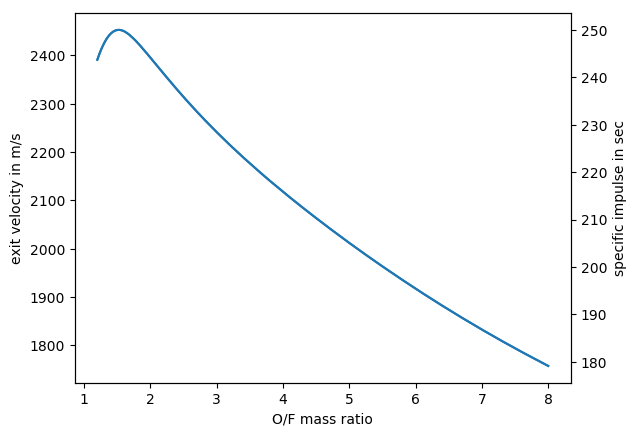

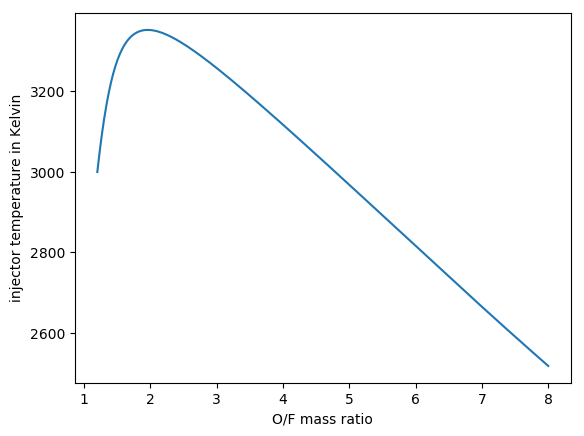

In [277]:
OFratio = np.linspace(1.2,8.0,200)
Isp = []
Tc = []
for r in OFratio:
    input_dict["OFratio"] = r
    res = runAll(input_dict)
    res_Isp = res["Isp"]
    res_Tc = res["injector temperature"]
    Isp.append(res_Isp)
    Tc.append(res_Tc)
Isp = np.array(Isp)
Tc = np.array(Tc)
fig, ax1 = plt.subplots()
ax1.plot(OFratio,Isp)
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(OFratio,Isp/9.81)
ax2.set_ylabel("specific impulse in sec")
ax1.set_xlabel("O/F mass ratio")
plt.show()

plt.plot(OFratio,Tc)
plt.xlabel("O/F mass ratio")
plt.ylabel("injector temperature in Kelvin")
plt.show()

This graph shows that a mass ratio of about 1.53 yields the maximum spcific impulse.

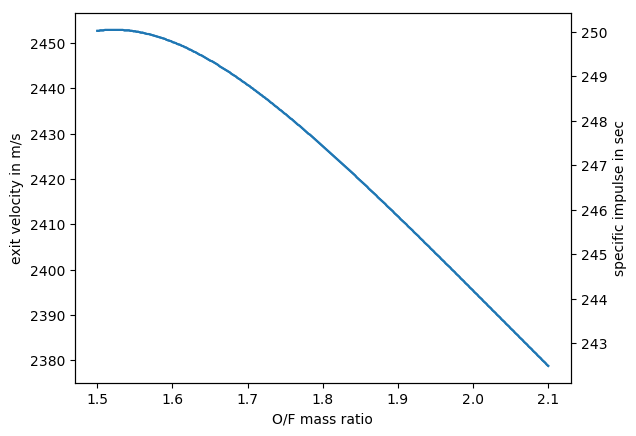

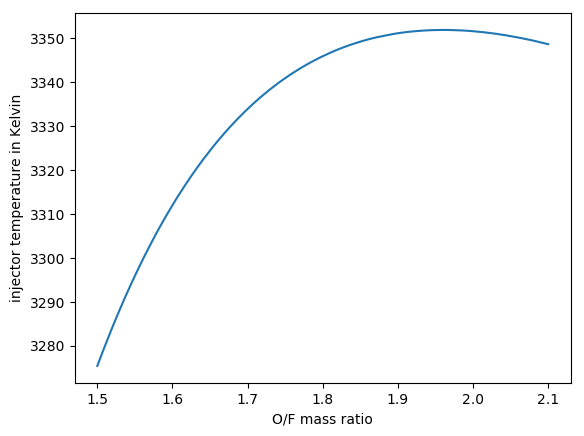

In [283]:
OFratio = np.linspace(1.5,2.1,300)#(1.5,1.55,300)
Isp = []
Tc = []
for r in OFratio:
    input_dict["OFratio"] = r
    res = runAll(input_dict)
    res_Isp = res["Isp"]
    res_Tc = res["injector temperature"]
    Isp.append(res_Isp)
    Tc.append(res_Tc)
Isp = np.array(Isp)*meter/sec
Tc = np.array(Tc)*Kelvin
fig, ax1 = plt.subplots()
ax1.plot(OFratio,Isp/(meter/sec))
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(OFratio,Isp/(9.81*meter/sec**2)/sec)
ax2.set_ylabel("specific impulse in sec")
ax1.set_xlabel("O/F mass ratio")
plt.show()

plt.plot(OFratio,Tc)
plt.xlabel("O/F mass ratio")
plt.ylabel("injector temperature in Kelvin")
plt.show()

The peak of the temperature happens at about O/F ~ 2.0, but the performance peak occurs before that, at O/F=1.53. This value is almost a 100 K cooler than the peak temperature which is definitely a bonus. Therefore we're choosing a mass ratio of 1.53.

In [285]:
fuel_density = species["ethanol"]["density"]
oxidizer_density = species["gaseous oxygen"]["density"]
print("volume ratio (O/F): {:.4}".format(1.53*fuel_density/oxidizer_density))

volume ratio (O/F): 844.8


## Isp vs. chamber-to-throat area ratio

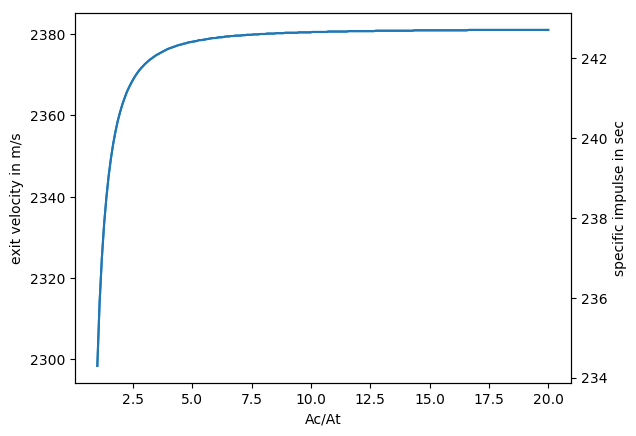

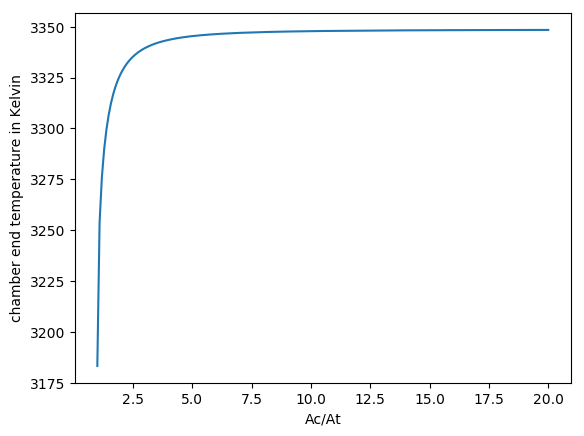

In [286]:
AcAt = np.linspace(1.0,20.0,200)
Isp = []
Tc = []
for r in AcAt:
    input_dict["chamber-to-throat area ratio"] = r
    res = runAll(input_dict)
    res_Isp = res["Isp"]
    res_Tc = res["chamber end temperature"]
    Isp.append(res_Isp)
    Tc.append(res_Tc)
Isp = np.array(Isp)*(meter/sec)
Tc = np.array(Tc)*Kelvin
fig, ax1 = plt.subplots()
ax1.plot(AcAt,Isp/(meter/sec))
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(AcAt,Isp/(9.81*meter/sec**2)/sec)
ax2.set_ylabel("specific impulse in sec")
ax1.set_xlabel("Ac/At")
plt.show()

plt.plot(AcAt,Tc)
plt.xlabel("Ac/At")
plt.ylabel("chamber end temperature in Kelvin")
plt.show()

Clearly the wider the chamber, the higher the performance will be, although improvements are minute after an area ratio of about ~5. Bigger chambers mean more area to cool which can significantly increase the weight of the engine or even prevent its feasibility altogether. Smaller ratios also have the advantage of enduring lower temperatures at the combustor's end, but since the temperature at the injector does is insentive to this ratio, the benefits of a lower temperature here do not outweigh the loss of specific impulse at ratios lower than 5.0 as would be required to significantly lower the end of the chamber's temperature.

## Isp vs. chamber pressure

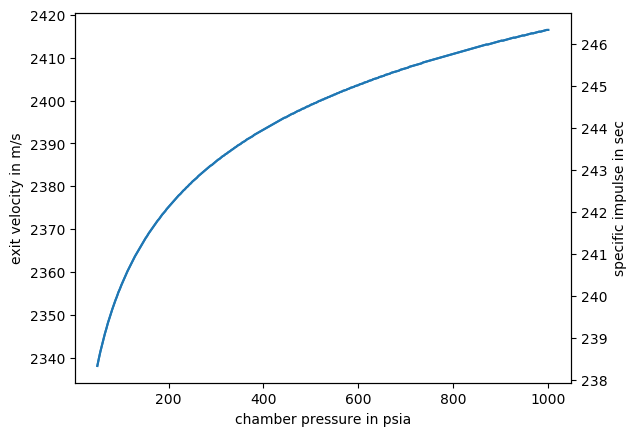

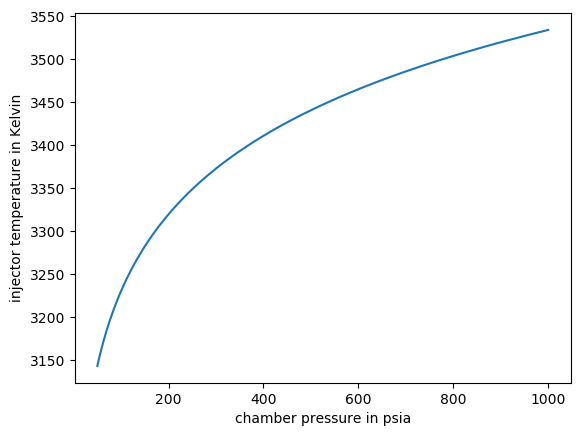

In [287]:
Pc = np.linspace(50,1000,300)*psi
Isp = []
Tc = []
for p in Pc:
    input_dict["chamber pressure"] = p/psi
    res = runAll(input_dict)
    res_Isp = res["Isp"]
    res_Tc = res["injector temperature"]
    Isp.append(res_Isp)
    Tc.append(res_Tc)
Isp = np.array(Isp)*(meter/sec)
Tc = np.array(Tc)*Kelvin
fig, ax1 = plt.subplots()
ax1.plot(Pc/psi,Isp/(meter/sec))
ax1.set_ylabel("exit velocity in m/s")
ax2 = ax1.twinx()
plt.plot(Pc/psi,Isp/(9.81*meter/sec**2)/sec)
ax2.set_ylabel("specific impulse in sec")
ax1.set_xlabel("chamber pressure in psia")
plt.show()

plt.plot(Pc/psi,Tc/Kelvin)
plt.xlabel("chamber pressure in psia")
plt.ylabel("injector temperature in Kelvin")
plt.show()

The engine's performance increases with the chamber's internal pressure. However, so does the temperature and of course the thickness of the walls, which means additional weight and technical difficulties. For those reasons, we will choose a chamber pressure of 250 psia.

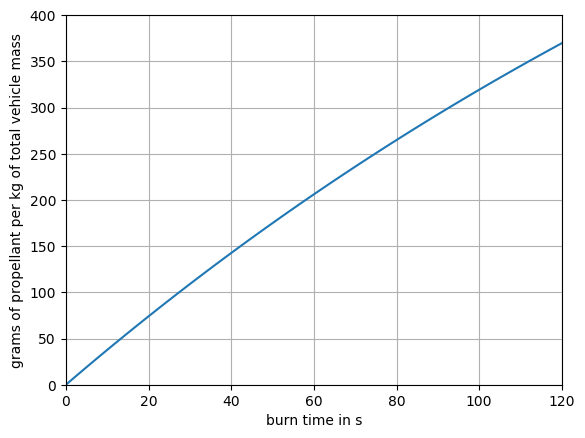

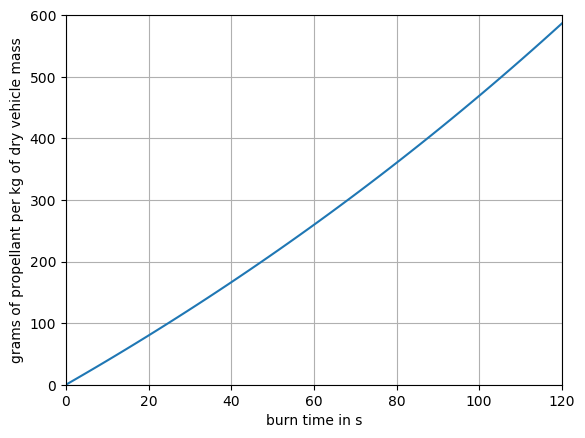

mass for a burn-time of 20 sec and vehicle mass of 50 kg: 19.9 kg


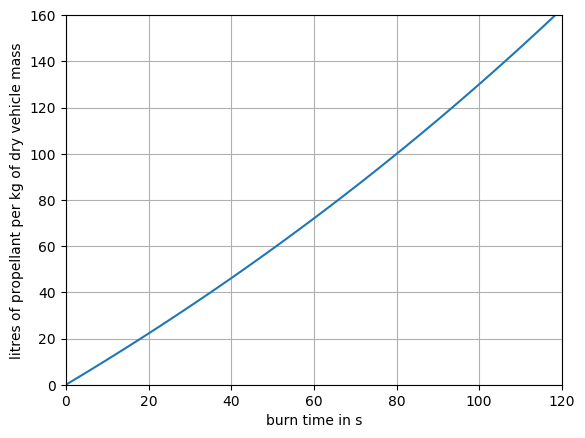

mass for a burn-time of 20 sec and vehicle mass of 50 kg: 1108.9 litres


In [291]:
burn_time = np.linspace(0, 120)*sec
Isp = 260*sec

mass_fraction = 1-np.exp(-burn_time/Isp)
plt.plot(burn_time/sec,mass_fraction/(gram/kg))
plt.xlabel("burn time in s")
plt.ylabel("grams of propellant per kg of total vehicle mass")
plt.xlim(0,120)
plt.ylim(0,400)
plt.grid(True)
plt.show()

mass_fraction = np.exp(burn_time/Isp)-1
plt.plot(burn_time/sec,mass_fraction/(gram/kg))
plt.xlabel("burn time in s")
plt.ylabel("grams of propellant per kg of dry vehicle mass")
plt.xlim(0,120)
plt.ylim(0,600)
plt.grid(True)
plt.show()
print("mass for a burn-time of 20 sec and vehicle mass of 50 kg: {:.3} kg".format(np.exp((20*sec/Isp)-1)/(kg/(50*kg))))

r = 1.53
volume_fraction = 1/(r+1)*(r/fuel_density+1/oxidizer_density)*(np.exp(burn_time/Isp)-1)
plt.plot(burn_time/sec,volume_fraction/(litre/kg))
plt.xlabel("burn time in s")
plt.ylabel("litres of propellant per kg of dry vehicle mass")
plt.xlim(0,120)
plt.ylim(0,160)
plt.grid(True)
plt.show()
print("mass for a burn-time of 20 sec and vehicle mass of 50 kg: {:.5} litres".format((1/(r+1)*(r/fuel_density+1/oxidizer_density)*(np.exp((20*sec)/Isp)-1))/(litre/(50*kg))))

## Engine design

In [315]:
Pe = 1*atm
Pc = 250*psi
Dc = 7*11.1*mm
Ac = np.pi/4*Dc**2
Dt = 2.1*cm
At = np.pi/4*Dt**2
r = 1.53
mdot = 0.1*kg/sec
wf = r/(r+1)*mdot
wo = 1/(r+1)*mdot
vf = wf/species["ethanol"]["density"]
vo = wo/species["gaseous oxygen"]["density"]

input_dict = {"case number":2005,
              "OFratio":r,
              "chamber-to-throat area ratio":Ac/At,
              "chamber temperature":2500,
              "chamber pressure":Pc/psi,
              "pressure ratio":Pc/Pe,
              "mass flux": mdot/Ac,
              "fuel":species["ethanol"]["name"],
              "fuel temperature":species["ethanol"]["temperature"],
              "oxidizer":species["gaseous oxygen"]["name"],
              "oxidizer temperature": species["gaseous oxygen"]["temperature"]
             }

result = runAll(input_dict)
Tc = result["injector temperature"]
Ae = result["throat-to-exit area ratio"]*At
De = np.sqrt(4*Ae/np.pi)
c = result["Isp"]
Isp = c/g0
F = mdot*c

print("CHAMBER CONDITIONS")
print("chamber pressure: {:.2f} MPa".format(Pc/MPa))
print("chamber temperature: {:.1f} Kelvin\n".format(Tc))
print("DIMENSIONS")
print("chamber diameter: {:.3f} cm".format(Dc/cm))
print("throat diameter: {:.3f} cm".format(Dt/cm))
print("exit diameter: {:.3f} cm\n".format(De/cm))
print("FLOWS")
print("fuel volume flow: {:.2f} litre/minute".format(vf/(litre/minute)))
print("oxidizer volume flow: {:.2f} litre/sec\n".format(vo/(litre/sec)))
print("PERFORMANCE")
print("specific impulse: {:.2f} sec".format(Isp/(sec)))
print("thrust: {:.2f} N ({:.2f} kgf)".format(F/Newton,F/kgf))

CHAMBER CONDITIONS
chamber pressure: 1.72 MPa
chamber temperature: 3288.3 Kelvin

DIMENSIONS
chamber diameter: 7.770 cm
throat diameter: 2.100 cm
exit diameter: 3.935 cm

FLOWS
fuel volume flow: 4.60 litre/minute
oxidizer volume flow: 27.66 litre/sec

PERFORMANCE
specific impulse: 250.24 sec
thrust: 245.49 N (25.02 kgf)


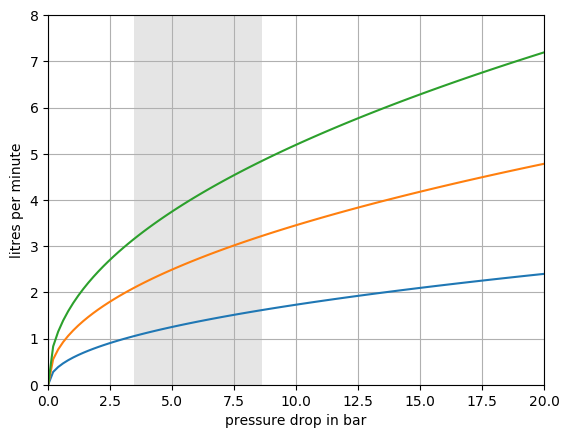

desired pressure drop: 3.45 - 8.62 bar


In [316]:
class Spray_Nozzle:
    
    def __init__(self, properties):
        self.K = properties["K"]
        self.source = properties["source"]
        self.reference = properties["reference"]
        
    def discharge(self,pressure):
        return (self.K*(pressure/bar)**0.47)*litre/minute
    
nozzles = []

nozzles.append(Spray_Nozzle({"K":0.587,
                        "source":"http://www.spray-nozzle.co.uk/docs/default-source/spec-sheet-pdf's/wl-low-flow-rate-full-cone-nozzle.pdf?sfvrsn=3",
                       "reference":"1/8 - WL 1/4"}))
nozzles.append(Spray_Nozzle({"K":1.17,
                        "source":"http://www.spray-nozzle.co.uk/docs/default-source/spec-sheet-pdf's/wl-low-flow-rate-full-cone-nozzle.pdf?sfvrsn=3",
                       "reference":"1/8 - WL 1/2"}))
nozzles.append(Spray_Nozzle({"K":1.76,
                        "source":"http://www.spray-nozzle.co.uk/docs/default-source/spec-sheet-pdf's/wl-low-flow-rate-full-cone-nozzle.pdf?sfvrsn=3",
                       "reference":"1/8 - WL 3/4"}))

pres = np.linspace(0,20,100)*bar
volmin = nozzles[0].discharge(pres)
plt.plot(pres/bar,volmin/(litre/minute))
volmin = nozzles[1].discharge(pres)
plt.plot(pres/bar,volmin/(litre/minute))
volmin = nozzles[2].discharge(pres)
plt.plot(pres/bar,volmin/(litre/minute))
plt.axvspan(0.2*Pc/bar, 0.5*Pc/bar, facecolor='0.8', alpha=0.5)
plt.xlabel("pressure drop in bar")
plt.ylabel("litres per minute")
plt.xlim(0,20)
plt.ylim(0,8)
plt.grid(True)
plt.show()
print("desired pressure drop: {:.2f} - {:.2f} bar".format(0.2*Pc/bar,0.5*Pc/bar))

In [317]:
Lc = 12.*cm
Vc = Lc*np.pi/4*Dc**2
Lsub = 1.0*cm
Vsub = integrate.quad(lambda y: np.pi*((Dc/2-Dt/2)/Lsub*y+Dt/2)**2, 0,Lsub)[0]
Lsup = 2*cm
Vsup = integrate.quad(lambda y: np.pi*((De/2-Dt/2)/Lsup*y+Dt/2)**2, 0,Lsup)[0]

print("combustion chamber length: {:.3f} cm".format(Lc/cm))
print("converging section length: {:.3f} cm".format(Lsub/cm))
print("diverging section length: {:.3f} cm".format(Lsup/cm))
print("L-star: {:.2f} cm (>{:.2f} cm)".format( (Vc+Vsub)/At/cm , 60*inch/cm ))
print("chamber length-to-diameter ratio: {:.2f}".format(Lc/Dc))

combustion chamber length: 12.000 cm
converging section length: 1.000 cm
diverging section length: 2.000 cm
L-star: 170.41 cm (>152.40 cm)
chamber length-to-diameter ratio: 1.54


In [321]:
S = 55*MPa
tw = 2 * Pc*Dc/2/S

print("chamber wall thickness: {:.2f} mm".format(tw/mm))

chamber wall thickness: 2.44 mm


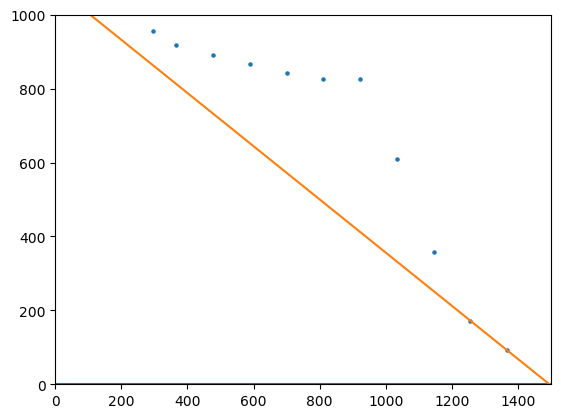

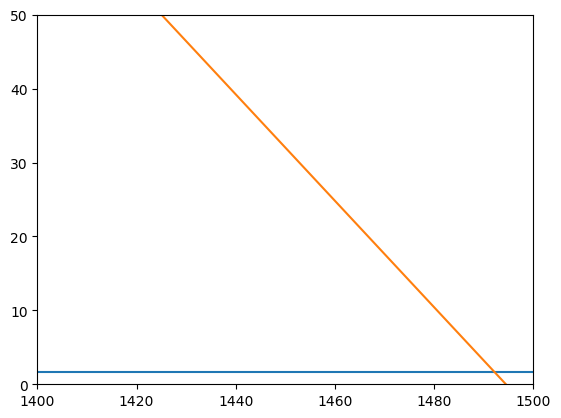

In [268]:
temperatures = np.array([73.4,200,400,600,800,1000,1200,1400,1600,1800,2000])*Rankine+Fahrenheit0
UTS = np.array([957,919,892,866,843,827,825,609,359,172,92])*MPa

line = linear_model.LinearRegression()
line.fit(temperatures[-2:].reshape(-1,1),UTS[-2:])
extended_temperatures = np.linspace(0,2000,100)
prediction = line.predict(extended_temperatures.reshape(-1,1))

pressure_limit = Pc+0*extended_temperatures

plt.scatter(temperatures/Kelvin,UTS/MPa,s=5)
plt.plot(extended_temperatures/Kelvin,pressure_limit/MPa)
plt.plot(extended_temperatures/Kelvin,prediction/MPa)
plt.ylim(0,1000)
plt.xlim(0,1500)
plt.show()

plt.scatter(temperatures/Kelvin,UTS/MPa,s=3)
plt.plot(extended_temperatures/Kelvin,pressure_limit/MPa)
plt.plot(extended_temperatures/Kelvin,prediction/MPa)
plt.ylim(0,50)
plt.xlim(1400,1500)
plt.show()

In [319]:
total_heated_area = np.pi*Dc*Lc
Ti = Celsius0+25*Kelvin
Tf = Celsius0+80*Kelvin
temperature_raise = Tf-Ti
wc = 85*Watt*meter/meter**2/Kelvin/(1*Joule/gram/Kelvin)*total_heated_area/tw*(Tc-Ti)/temperature_raise
print("temperature raise: {:.1f} Kelvin".format(temperature_raise/Kelvin))
print("water flow : {:.2f} kg/sec".format(wc/(kg/sec)))

temperature raise: 55.0 Kelvin
water flow : 37.05 kg/sec


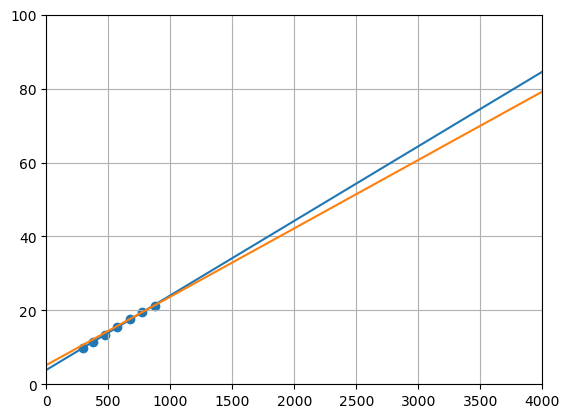

In [267]:
temperatures = np.array([23,100,200,300,400,500,600])*Kelvin+Celsius0
thermal_conductivities = np.array([9.8,11.4,13.4,15.5,17.6,19.6,21.3])*Watt/meter/Kelvin

line_1 = linear_model.LinearRegression()
line_1.fit(temperatures.reshape(-1,1),thermal_conductivities)
extended_temperatures_1 = np.linspace(0,4000,100)
prediction_1 = line_1.predict(extended_temperatures_1.reshape(-1,1))

line_2 = linear_model.LinearRegression()
line_2.fit(temperatures[-3:].reshape(-1,1),thermal_conductivities[-3:])
extended_temperatures_2 = np.linspace(0,4000,100)
prediction_2 = line_2.predict(extended_temperatures_2.reshape(-1,1))


plt.scatter(temperatures,thermal_conductivities)
plt.plot(extended_temperatures_1,prediction_1)
plt.plot(extended_temperatures_2,prediction_2)
plt.xlim(0,4000)
plt.ylim(0,100)
plt.grid(True)
plt.show()